In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

%matplotlib inline
sns.set(rc={'figure.figsize':(11.7,8.27)})

## Cleaning the data

In [2]:
df : pd.DataFrame = pd.read_csv('my_data.csv')

In [3]:
df.head()

,Unnamed: 0,year,make,model,mileage,title,state of origin,engine size,engine type,drivetrain,transmmision type,number of gears,body_style,color,numberg of higlights,number of flaws,price
0,0,1999,Mercedes-Benz,SL600,"52,000",Clean,NJ,6.0L,V12,Rear-wheel drive,Automatic,5-Speed,Convertible,Black,5,3,"$30,500"
1,1,2017,BMW,330i,"43,400",Clean,KS,2.0L,I4,4WD/AWD,Automatic,8-Speed,Wagon,Glacier Silver,6,4,"$41,500"
2,2,2008,MINI,Cooper Clubman,"104,100",Clean,TN,1.6L,I4,Front-wheel drive,Manual,6-Speed,Wagon,Hot Chocolate Metallic,5,11,"$9,969"
3,3,2013,Porsche,Cayenne,"82,400",Clean,CA,4.8L,V8,4WD/AWD,Automatic,8-Speed,SUV/Crossover,Meteor Grey Metallic,4,2,"$29,000"
4,4,2019,Chevrolet,Camaro,"9,500",Clean,NY,6.2L,V8,Rear-wheel drive,Automatic,10-Speed,Coupe,Riverside Blue Metallic,4,3,"$60,333"


in one page there was no year of prduction, insted it was "Consumer" somthing.. so I just deleted this row,  + the Unamed:0 colum the was the resualt of combing of all the dataframes from the scrapper.

In [4]:
df = df.drop("Unnamed: 0",axis=1)
df = df.drop(df.loc[df['year'] == '"Consumer'].index)

### fixing the numerical columns

Some columns are in numbers, but becuase there was a charecter in them ('$',',','L') so I needed to prase the change them to numerical data(int/float)

In the price column all we need to do is to remove the '$' symbol infront and remove the ','

In [5]:
df["price"] = df["price"].apply(lambda x: x[1:])
df["price"] = df["price"].apply(lambda x: x.replace(",",""))

In the mileage column, we remove the ',' smbol as well as the '~' symbol that were on one car.
moreover their were some comments on the mileage column, that said xxxx miles on the odometer, I also got rid of them.

In [6]:
def get_miles_from_str(x):
    if isinstance(x,int):
        return x
    x = x.replace(",","")
    x = x.split(" ")[0]
    x = x.replace("~","")
    if x[0].isdigit():
        return x
    return 0

df["mileage"] = df["mileage"].apply(lambda x: get_miles_from_str(x))

In the engine colum their were more problems. Some were electric, some in Liters, some in cc and some were completlly missing.
I fixed the missing manually by checking simmilar cars. 
all of the Electric cars were given 0 engine size, and all the other car's engine size were represented in cc

In [7]:
df["engine size"] = df["engine size"].replace(['Single','Dual','Triple','AC'],0)
def convert(x : str):
    if isinstance(x,int):
        return x
    elif "cc" in x:
        x = x.replace("cc","")
    elif "L" in x:
        x = x.replace("L","")
        x = x.replace(".","")
        for i in range(0,4 -len(x)):
            x = x + "0"
    elif "." in x:
        x = x.replace(".","")
        for i in range(0,4 -len(x)):
            x = x + "0"

    return x

df["engine size"] = df["engine size"].apply(convert)


df.loc[df["engine size"] == "Toronto","engine size"] = 5700
df.loc[df["engine size"] == "Chevrolet","engine size"] = 3200
df.loc[df["engine size"] == "AC","engine size"] = 0
df.loc[df["engine size"] == "EV","engine size"] = 0
df.iloc[3834,6] = 4600
df.iloc[3926,6] = 4000

again, not all post were equal. So I had to fix it manually.

I also combined all the same engines, that had different names like "I4", "Inline-4","i-4" etc...

In [8]:
df.loc[df["engine type"] == "Canada","engine type"] = "Flat-6"
df.loc[df["engine type"] == "Supercharged","engine type"] = "V6"
df.loc[df["engine type"] == "Diesel","engine type"] = "I4"
df.loc[df["engine type"] == "3.0L","engine type"] = "I6"
df.loc[df["engine type"] == "turbodiesel","engine type"] = "I6"
df.loc[df["engine type"] == "I-6","engine type"] = "I6"
df.loc[df["engine type"] == "Turbodiesel","engine type"] = "V6"
df.loc[df["engine type"] == "Turbo","engine type"] = "I4"
df.loc[df["engine type"] == "4","engine type"] = "Flat-4"
df.loc[df["engine type"] == "6","engine type"] = "Flat-6"
df.loc[df["engine type"] == "Inline-4","engine type"] = "I4"
df.loc[df["engine type"] == "i4","engine type"] = "I4"
df.loc[df["engine type"] == "I-4","engine type"] = "I4"
df.loc[df["engine type"] == "I-3","engine type"] = "I3"
df.loc[df["engine type"] == "Hybrid","engine type"] = "V6"
df.loc[df["engine type"] == "H6","engine type"] = "Flat-6"
df.loc[df["engine type"] == "H4","engine type"] = "Flat-4"
df.loc[df["engine size"] == 0,"engine type"] = "electric"

I changed the number of gears, so that I have this column in integers. and again' needed to fix some values manually

In [9]:
df.loc[df["number of gears"] == "3.6L V6","number of gears"] = "6-speed"
def simplefy_gears(x:str):
    if not isinstance(x,str):
        return 0
    if x == "CVT":
        return -1
    x = x.split("-")[0]
    return x

df["number of gears"] = df["number of gears"].apply(simplefy_gears)

There were to many collor. So I grouped all of them together

In [10]:
def simplefy_color(x : str):
    if "white" in x.lower():
        x = "white"
    elif "black" in x.lower():
        x = "black"
    elif "red" in x.lower():
        x = "red"
    elif "blue" in x.lower():
        x = "blue"
    elif "yellow" in x.lower():
        x = "yellow"
    elif "grey" in x.lower():
        x = "grey"
    elif "green" in x.lower():
        x = "green"
    elif "silver" in x.lower():
        x = "silver"
    elif "orange" in x.lower():
        x = "orange"
    elif "metallic" in x.lower():
        x = "metallic"
    elif "pearl" in x.lower():
        x = "pearl"
    elif "gold" in x.lower():
        x = "gold"
    elif "beige" in x.lower():
        x = "beige"
    else:
        x = "special"

    return x

df["color"] = df["color"].apply(simplefy_color)

In [11]:
df["price"] = df['price'].astype(str).astype(int)
df["mileage"] = df['mileage'].astype(str).astype(int)
df["year"] = df['year'].astype(str).astype(int)
df["engine size"] = df['engine size'].astype(str).astype(int)
df["number of gears"] = df['number of gears'].astype(str).astype(int)

Almost all of the cars were clean, so that data does not make differance, and we can drop it

In [12]:
df = df.drop("title",axis=1)

I combined this cloumn to describe how detailed was the post. It made sense that a more detailed post, were bidded higher

In [13]:
df["is descreptive"] = df["numberg of higlights"] + df["number of flaws"] > 15
df["is descreptive"] = df["is descreptive"].map({
    True: 1,
    False: 0
})

df = df.drop(["numberg of higlights","number of flaws"],axis=1)

In [14]:
df.describe(include='all')

,year,make,model,mileage,state of origin,engine size,engine type,drivetrain,transmmision type,number of gears,body_style,color,price,is descreptive
count,5419.000000,5419,5419,5419.000000,5419,5419.000000,5419,5419,5419,5419.000000,5419,5419,5419.000000,5419.000000
unique,NaN,93,783,NaN,64,NaN,18,3,2,NaN,8,14,NaN,NaN
top,NaN,BMW,911,NaN,CA,NaN,V8,Rear-wheel drive,Automatic,NaN,Sedan,black,NaN,NaN
freq,NaN,1017,146,NaN,1038,NaN,2034,2948,3149,NaN,1358,1164,NaN,NaN
mean,2004.143015,NaN,NaN,78872.090238,NaN,3714.847204,NaN,NaN,NaN,5.539029,NaN,NaN,23781.286584,0.132681
std,9.439459,NaN,NaN,54907.551792,NaN,1473.926754,NaN,NaN,NaN,1.316372,NaN,NaN,25207.455644,0.339261
min,1981.000000,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,-1.000000,NaN,NaN,1800.000000,0.000000
25%,1998.000000,NaN,NaN,37900.000000,NaN,2500.000000,NaN,NaN,NaN,5.000000,NaN,NaN,9400.000000,0.000000
50%,2005.000000,NaN,NaN,69900.000000,NaN,3500.000000,NaN,NaN,NaN,6.000000,NaN,NaN,16000.000000,0.000000
75%,2012.000000,NaN,NaN,109700.000000,NaN,4900.000000,NaN,NaN,NaN,6.000000,NaN,NaN,27750.000000,0.000000


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5419 entries, 0 to 5419
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   year               5419 non-null   int64 
 1   make               5419 non-null   object
 2   model              5419 non-null   object
 3   mileage            5419 non-null   int64 
 4   state of origin    5419 non-null   object
 5   engine size        5419 non-null   int64 
 6   engine type        5419 non-null   object
 7   drivetrain         5419 non-null   object
 8   transmmision type  5419 non-null   object
 9   number of gears    5419 non-null   int64 
 10  body_style         5419 non-null   object
 11  color              5419 non-null   object
 12  price              5419 non-null   int64 
 13  is descreptive     5419 non-null   int64 
dtypes: int64(6), object(8)
memory usage: 635.0+ KB


array([[<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'mileage'}>],
       [<AxesSubplot:title={'center':'engine size'}>,
        <AxesSubplot:title={'center':'number of gears'}>],
       [<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'is descreptive'}>]], dtype=object)

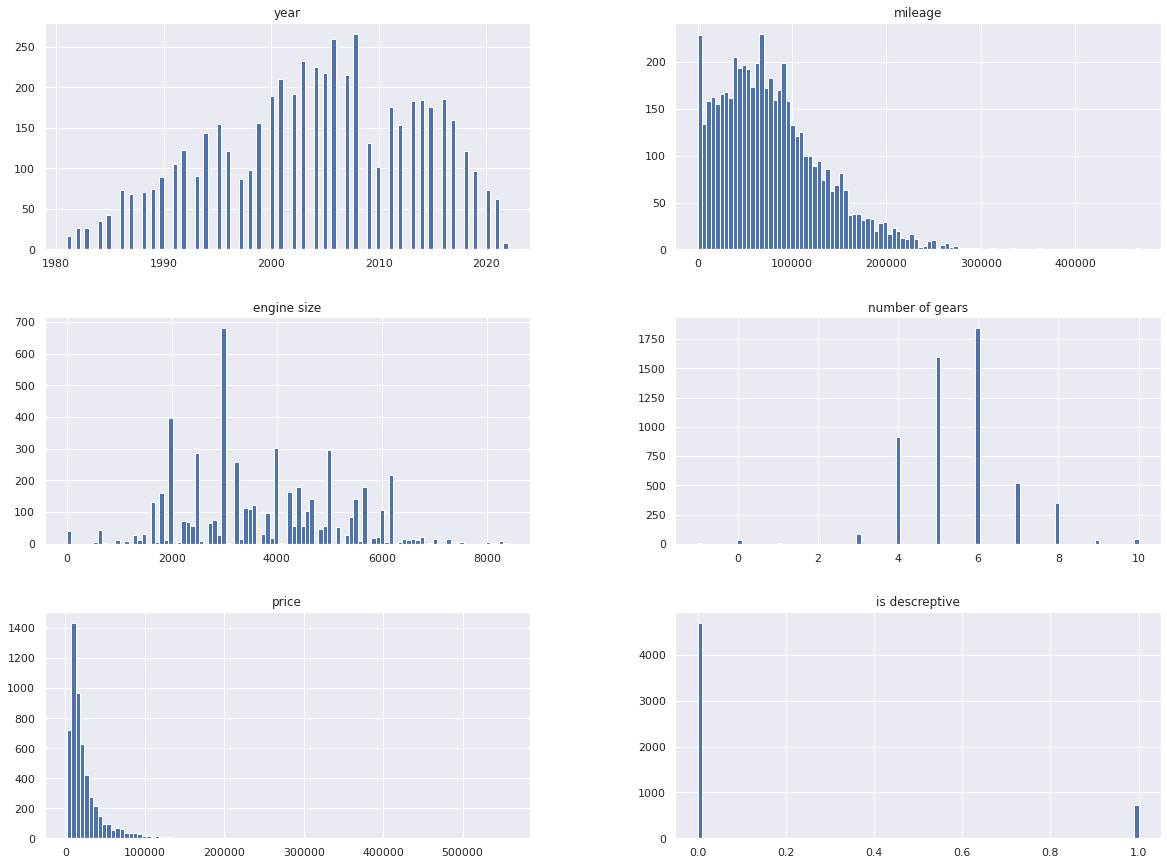

In [16]:
df.hist(bins=100, figsize=(20,15))

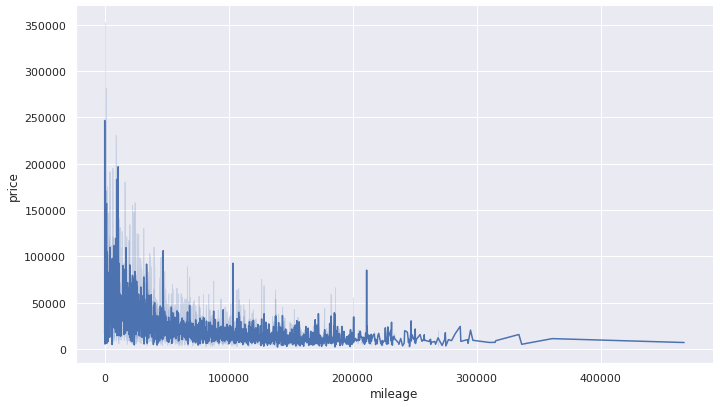

In [17]:
mileage_price_rel = sns.relplot(x="mileage", y="price" ,data=df,kind='line')
mileage_price_rel.fig.set_figwidth(12)
mileage_price_rel.fig.set_figheight(6)

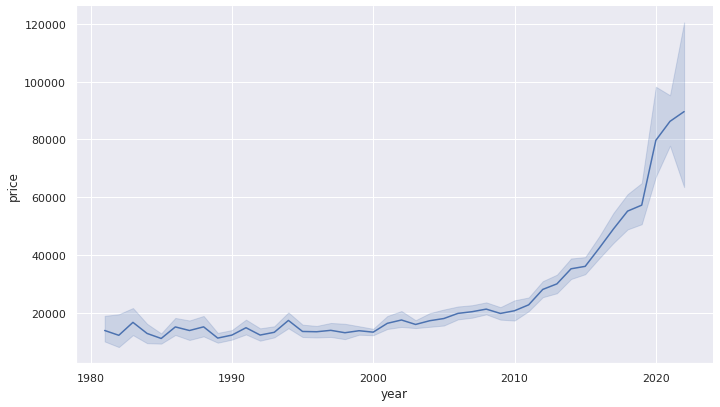

In [18]:
year_price_rel = sns.relplot(x="year", y="price" ,data=df,kind='line')
year_price_rel.fig.set_figwidth(12)
year_price_rel.fig.set_figheight(6)

We can see that the data is scatterd around, and althoguht their is slight increse in engine size comparred to the price, it still looks quite random.

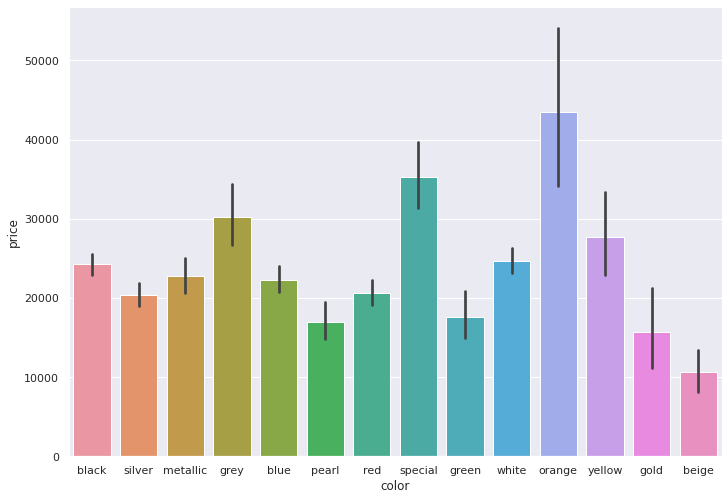

In [19]:
color_price_rel = sns.barplot(x="color", y="price" ,data=df)

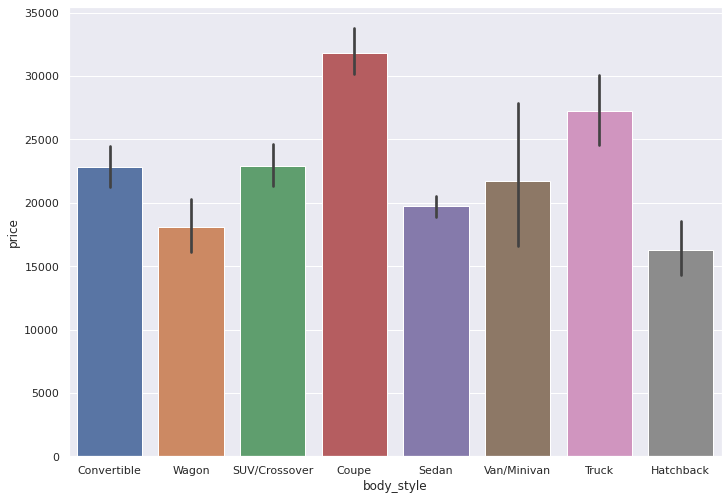

In [20]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
body_price_rel = sns.barplot(x="body_style", y="price" ,data=df)

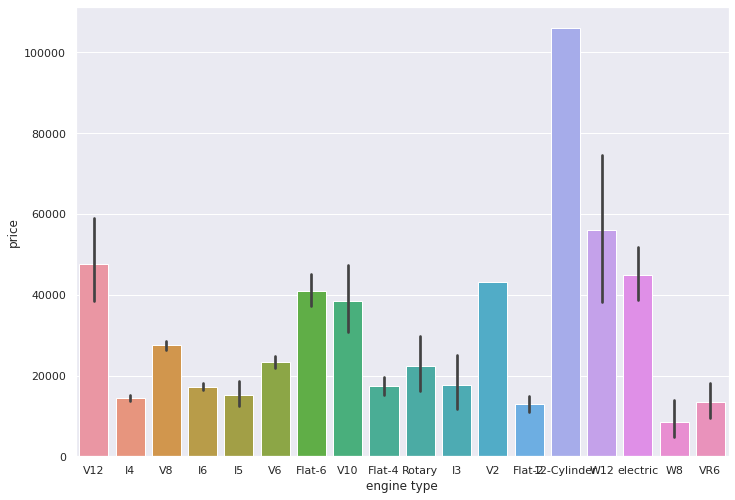

In [21]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
body_price_rel = sns.barplot(x="engine type", y="price" ,data=df)

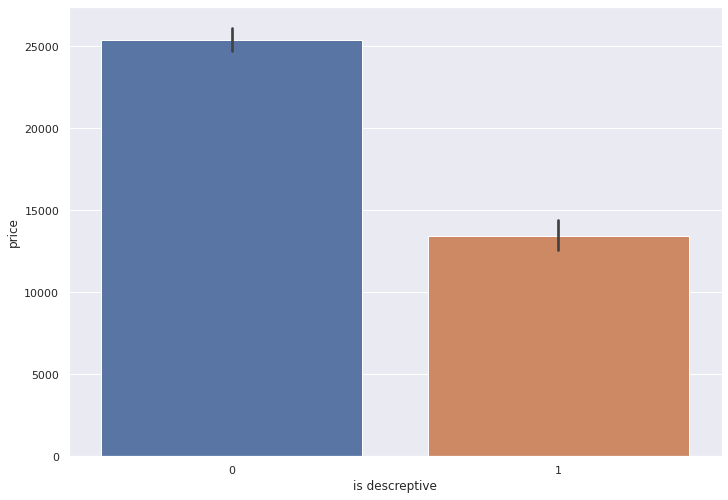

In [22]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
body_price_rel = sns.barplot(x="is descreptive", y="price" ,data=df)

In [23]:
df = df.drop(df.loc[(df["price"] > 100000)].index)
df = df.drop(df.loc[(df["mileage"] > 300000)].index)

In [24]:
df = df.drop(df[df.groupby('make')['make'].transform('size') <= 5].index)

In [38]:
cars_df_with_dummies = pd.get_dummies(df)

In [35]:
cars_df_with_dummies

,year,make,model,mileage,state of origin,engine size,engine type,drivetrain,transmmision type,number of gears,body_style,color,price,is descreptive
0,1999,Mercedes-Benz,SL600,52000,NJ,6000,V12,Rear-wheel drive,Automatic,5,Convertible,black,30500,0
1,2017,BMW,330i,43400,KS,2000,I4,4WD/AWD,Automatic,8,Wagon,silver,41500,0
2,2008,MINI,Cooper Clubman,104100,TN,1600,I4,Front-wheel drive,Manual,6,Wagon,metallic,9969,1
3,2013,Porsche,Cayenne,82400,CA,4800,V8,4WD/AWD,Automatic,8,SUV/Crossover,grey,29000,0
4,2019,Chevrolet,Camaro,9500,NY,6200,V8,Rear-wheel drive,Automatic,10,Coupe,blue,60333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5415,2013,BMW,M5,48900,NY,4400,V8,Rear-wheel drive,Automatic,7,Sedan,blue,30750,0
5416,2006,Mazda,Mazdaspeed 6,109900,FL,2300,I4,4WD/AWD,Manual,6,Sedan,metallic,6700,1
5417,2007,Aston Martin,V8 Vantage,63800,NY,4300,V8,Rear-wheel drive,Manual,6,Coupe,black,33500,0
5418,1986,Dodge,600,88800,PA,2500,I4,Front-wheel drive,Automatic,3,Coupe,beige,1800,0


In [46]:
from sklearn.preprocessing import MinMaxScaler
std_scaler = MinMaxScaler()

price_label = cars_df_with_dummies['price']
cars_without_price = cars_df_with_dummies.drop(['price'],axis=1)

X_train,X_test,y_train,y_test = train_test_split(cars_without_price,price_label,test_size=0.2,random_state=0)

num_features = ['year','mileage','engine size','number of gears']

X_train[num_features] = std_scaler.fit_transform(X_train[num_features])
X_test[num_features] = std_scaler.transform(X_test[num_features])



/home/daniel/.local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/home/daniel/.local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/home/daniel/.local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/home/daniel/.local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/home/daniel/.local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/home

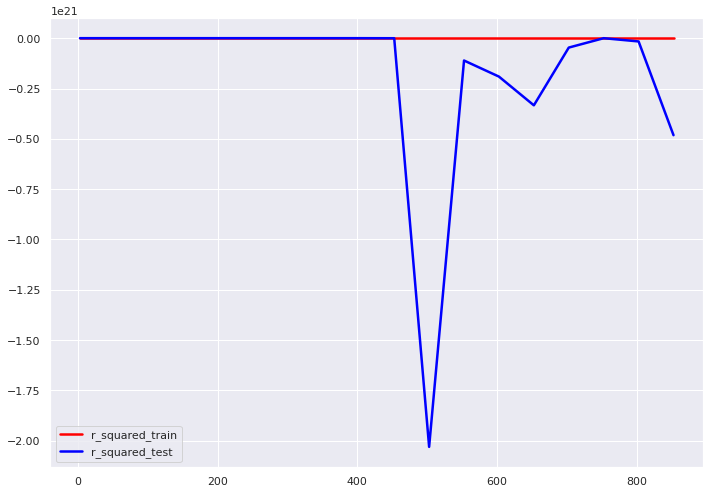

In [47]:
column_names = cars_df_with_dummies.drop(columns = ['price']).columns

no_of_features = []
r_squared_train = []
r_squared_test = []


for k in range(3, 870, 50): # From 3 to 35 variables (every single one)
    selector = SelectKBest(f_regression, k = k)
    X_train_transformed = selector.fit_transform(X_train, y_train)
    X_test_transformed = selector.transform(X_test)
    regressor = LinearRegression()
    regressor.fit(X_train_transformed, y_train)
    no_of_features.append(k)
    r_squared_train.append(regressor.score(X_train_transformed, y_train))
    r_squared_test.append(regressor.score(X_test_transformed, y_test))
    

sns.lineplot(x = no_of_features, y = r_squared_train, legend = 'full', color='red', linewidth=2.5, label="r_squared_train")
sns.lineplot(x = no_of_features, y = r_squared_test, legend = 'full', color='blue', linewidth=2.5, label="r_squared_test")
plt.show()

In [48]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error as MAE

kf = KFold(n_splits=10, random_state=42, shuffle=True)
LR = LinearRegression()

R2_standardized = cross_val_score(LR, X_train, y_train, cv=kf)
y_predict_standardized = cross_val_predict(LR, X_train, y_train, cv=kf)
mae_standarsized = MAE(y_train, y_predict_standardized)

print('standartize:')
print('R2 score: ' + str(R2_standardized.mean())[:6])
print('R2 std: ' + str(R2_standardized.std())[:6])
print('MAE: ' + str(mae_standarsized)[:6])


standartize:
R2 score: -5.069
R2 std: 1.0003
MAE: 476900


In [49]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
initial_prediction = linear_reg.predict(X_test)


print(linear_reg.score(X_test,y_test))
print (mean_squared_error(y_test,initial_prediction))

-3.2688680149275124e+19
1.102824179395338e+28


In [50]:
knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train, y_train)
initial_prediction = knn_reg.predict(X_test)


print(knn_reg.score(X_test,y_test))
print (mean_squared_error(y_test,initial_prediction))

0.65882804113832
115101828.47583571


In [51]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)
initial_prediction = rf_reg.predict(X_test)


print(rf_reg.score(X_test,y_test))
print (mean_squared_error(y_test,initial_prediction))

0.8259563268431497
58717442.90428627
